In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import numpy.random as random

sns.set(style="whitegrid")

# Bias/Variance Trade Off

When you're done with N-Fold Cross Validation, you have an estimate of the performance of your model ("generalization error" although you might not have calculated *error*) and a credible interval for it.
Let's say the mean value of a regression model has a standard error (square root of the mean MSE) of 23.7.
Now, whether and by much a given model is good or bad depends entirely on the real world problem.
Plus or minus 23.7 would be great if the base value is 1,305 but maybe not so great if the base value is 139.0.
I can't tell you how good--in absolute terms--your model is.
The answer to that question is, is it better than what you do now (guessing, estimate, or current model)?

But let's say the standard error is 23.7 and that's not as good as you'd hoped.
How can we make the model better?
In previous chapters, we've taken a domain knowledge centric approach to some of these potential solutions.
Does your "theory" indicate you're missing a variable?
Does your theory/EDA/residuals indicate that a variable should be transformed?

The *usual* suspects are things like:

1. get more observations
2. get more features or transform them.
3. apply regularization
4. change metaparameters
5. change models

Now what if I told you that getting more observations doesn't always work, you may need to *remove* features, you shouldn't transform those features, or you might even need to remove regularization (which we'll talk about in a bit...just think "smoothing")?

In order to get a good indication of what we're going to do, we're going to need a framework.
That framework is the Bias/Variance Trade Off.
But first, some Computational Learning Theory...

## Just Enough Theory

Because this is not a machine learning class, I'm only going to give you just enough Computational Learning Theory to get you by.
However, the basics are not complicated.

In the abstract, we have some data $(X, y)$ and we want to model $y$ with $X$.
We assert that there is some true relationship, $g$, between $X$ and $y$ but we cannot observe $y = g(X)$ directly.
We do not even know its shape.
This the problem of inference in the context of Machine Learning.

We can represent this true relationship using a model $y = f(X)$ where $f$ becomes an approximation of $g$.
But since we don't know $g$ and have no idea what $g$ looks like, we have to pick *some* starting place for $f$.
Do we pick a constant value (like the mean or median), a line (linear regression, SVM), an artificial neural network, or a decision tree?
Picking a particular *form* for $f$ is known as *representational bias*.
In this case, *bias* is a good thing.
It was proven a long time ago, that if you don't want to just memorize your data, you need to pick a representation of some kind.

Now that we have picked a form for $f$, we need to estimate it.
This requires an algorithm as well which we will call $F$, $f = F(X, y)$.
$F$ finds $f$.
It is in this sense that Herbert Simon quipped, "all of AI is search".
The algorithm, $F$, to find $f$ introduces another bias, the *inductive bias*.
A good example of this comes from Decision Trees where a decision tree $f$ can be learned using different algorithms such as CART (Classification and Regression Trees), CHAID (Chi-Square Automatic Interaction Detection), C4.5, and others, all different versions of $F$.
Variations on $F$ can be introduced by using different loss functions as well.

For linear regression, our representation bias is the form of $f$ or a straight line and the inductive bias is mean squared error.
You may have heard that linear regression ("Ordinary Least Squares") is "BLUE" (Best Linear Unbiased Estimator) and you'll wonder why I've now said it is biased.
This is because "bias" means different things (albeit related) in statistics than machine learning.
But in this context, "bias" in statistics and BLUE means how well it estimates a population parameter from a sample.
A little bit of that is in the Machine Learning difference.
You can think of $g$ as being the population relationship and $f$ as being the estimate from a sample.
Even so, in machine learning, bias can never be eliminated (and it is undesirable to do so).

It is interesting to note that Scikit Learn is set up this way in general:

```
1. linear = LinearRegression() # F
2. model = linear.fit(X, y)    # F -> f
3. y_hat = model.predict(X)    # f
```

In line 1, we create a class for $F$, possibly supplying "meta parameters" (a meta parameter or hyperparameter is a parameter that we pick instead of one that is learned from the data. They usually apply to $F$ but can apply to $f$ as well).
In line 2, we fit the model itself. That is, we take $F$, $X$ and $y$ and generate $f$.
In line 3, we can apply $f$ to a new batch of data, $X$, and get estimates, $\hat{y}$.


## Prejudice
It's very important that your machine learning models do not incorporate *prejudice* by copying such prejudicial and discriminatory actions that may appear your data.
This kind of *social* bias in machine learning has received a lot of well deserved attention.
We have to be clear, however, that *bias* is a technical term in our field as well.
When I say "machine learning models must always be biased", I mean that representational bias and inductive bias cannot be eliminated. They shouldn't be *discriminatory*, however.

# The Tradeoff

We are now in a position to talk about the general framework for discussing predictive modeling: the bias/variance tradeoff. We will take the case of regression because it is a bit easier to visualize. However, the framework can be formulated for classification problems as well as models other than linear regression. If we take our most basic predictive model for regression:

$\hat{y} = \beta_0 + \epsilon$

we can ask ourselves, where does our error $y - \hat{y}$ come from? Conceptually, there are three components of error:

1. **bias** (error) comes from our selection of the model itself, $\beta_0$, which may *underfit* the data.
2. **variance** (error) comes from the sensitivity of $\beta_0$ to outliers which may *overfit* the data.
3. **irreducible error** comes from $\epsilon$ often called "noise", a term I do not like...you can think of it as coming from Rumsfeld's "known unknowns" and "unknown unknowns".

For the most part, we do not have control over **irreducible** error but we may have control over **bias** and **variance**. The problem is that there is generally a *tradeoff*; descreasing one increases the other. Consider a regression problem such as the following:

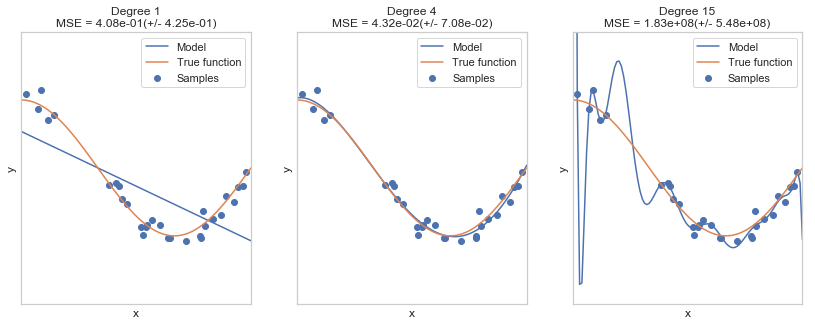

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))

plt.show()
plt.close()

[source](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

In each panel, we show a sampling of data (dots) from a true relationship (green line, $g$) and the resulting model (blue line, $f$). The first model is:

$\hat{y} = \beta_0 + \beta_1 x_1 + \epsilon$

The results for this model are shown in the first panel. This model has a mean squared error or MSE of 4.08e-01 on average. Ignoring $\epsilon$ you can think of *bias* as the difference in the blue dots and the blue line (our data and our model) and *variance* as the difference in the green line and the blue line (the real relationship and our model).

We see that both bias and variance are pretty high but as new data points are observed (somewhere along the green line), the model is going to be pretty consistent in its predictions (along the blue line). We generally call this the "high bias/low variance" case. What we're really saying is that our model was very "opinionated" about the kinds of predictions it would make and took less of the shape of the data into account than we might have liked (representational bias from above). In essence, we "underfit" the data. This is going to *bias* the error of the predictions.

The third model is:

$\hat{y} = \beta_0 + \beta_1 (x_1^{15}) + \epsilon$

The results for this model are shown in the third panel. We see that bias is quite low...the blue line goes through most of (not all of) the blue dots. But the *variance* is going to be quite high. If you look where there was no data sampled along the green line, the blue line (prediction) is going to be quite wrong in a lot of spots. This is the high variance/low bias case. In a sense, the model was not opinionated enough. We "overfit" the data. There is going to be large *variance* in the error of the predictions.

The second model is:

$\hat{y} = \beta_0 + \beta_1 (x_1^4) + \epsilon$

The results for this model are in the middle panel. Just like Goldilocks, the middle panel shows the case of bias/variance balance. We have not eliminated both types of error. There are cases where the blue dots are quite far from the blue line and there are cases where the blue and green lines diverge. Although it is idealized, it illustrates the concept of what we're aiming for. The problem, of course, is that we can never observe the green line, $g$.

The question of improving a model based on the five solutions we asked earlier,

1. get more observations
2. get more features or transform them.
3. apply regularization
4. change metaparameters
5. change models

becomes, how do you know if you're in panel 1, 2 or 3 and what do you do about it?
As a result, the five solutions become:

1. get more observations *or not*
2. get more features or transform them *or not*
3. apply regularization *or not*
4. change metaparameters *which way?*
5. change models *what kind?*